In [1]:
import pandas as pd
import json
import sys
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import boto3,os

from datasets.ppi_multiclass_label_mapper import PpiMulticlassLabelMapper

sys.path.append("../src")

from sklearn.metrics import plot_confusion_matrix

In [2]:
temp_dir = tempfile.mkdtemp()
s3_val_pred_ensemble_file_f1="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-9_2021052215/val_multiclass.json.json"
s3_test_pred_ensemble_file_f1="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-9_2021052215/test_multiclass.json.json"
s3_train_pred_ensemble_file_f1='s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-9_2021052910/train_multiclass.json.json'

s3_val_pred_ensemble_file_loss ="s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-2021-05-08-17-10_2021050918/val_multiclass.json.json"
s3_test_pred_ensemble_file_loss = "s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-2021-05-08-17-10_2021050918/test_multiclass.json.json"
label_mapper = PpiMulticlassLabelMapper()


In [3]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [4]:
s3_val_pred_ensemble_file = s3_val_pred_ensemble_file_f1
s3_test_pred_ensemble_file = s3_test_pred_ensemble_file_f1
s3_train_pred_ensemble_file = s3_train_pred_ensemble_file_f1

In [5]:
def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
    return local_file

In [6]:


def is_group_correct(actual , predicted):
    neutral_map = {
        "phosphorylation" : "phos",
        "dephosphorylation" : "phos"

    }
    return neutral_map.get(actual , actual) == neutral_map.get(predicted , predicted) 

def _reverse_uniprot_name_map(uniprot, gene_to_prot_map, annot):
    uniprot_matches = list(filter(lambda x:uniprot in gene_to_prot_map[x] , gene_to_prot_map))
    
    if len(uniprot_matches) == 0: return None
    
    for a in annot:
       
        if a["normalised_id"] == uniprot_matches[0]:
            return a["name"]


    
    
def load_ensemble_output(data_file):
    df = pd.read_json ( data_file)
    df = df.rename( columns= {
        "class" :"actual"
    })
   # df["variance"] = df["conf_var"].apply(lambda x: x*x)
    df["participant1Name"] = df[["participant1Id", "gene_to_uniprot_map", "annotations"]]\
                                .apply( lambda x: _reverse_uniprot_name_map(*x), axis=1 )
    df["participant2Name"] = df[["participant2Id", "gene_to_uniprot_map", "annotations"]]\
                                .apply( lambda x: _reverse_uniprot_name_map(*x), axis=1 )


    df["correct"] = df["actual"] == df["prediction"]
    df["group_correct"] = df.apply(lambda x: is_group_correct(x["actual"], x["prediction"]) , axis=1)
    
    return df

    

In [7]:
import sklearn.metrics, math
from scorers.result_scorer_ece import ResultScorerEce


def _get_ece(df, actual_label):
    if len(df) ==0 : return pd.NA
    
    sorted_labels = sorted (labels, key=lambda x: label_mapper.map(x) )
    
    actual_indices = df[actual_label].apply(label_mapper.map)
    predicted_conf = df[sorted_labels]
    
    scorer= ResultScorerEce()

    ece_error = scorer(df[actual_label], predicted_conf)
    
    return ece_error

def _get_avg_confidence_variance(df, confidence_var_label):
    return math.sqrt( df[confidence_var_label].apply(lambda x: x * x).mean())

def create_classification_report(df, actual_label, pred_label, confidence_var_label, labels=None):
  
    score_report_dict = sklearn.metrics.classification_report( df[actual_label], 
                                                              df[pred_label], 
                                                              output_dict=True, 
                                                              labels=labels)
    

    score_report_dict_transformed = []
    
    summary = {}
    for k, v in   score_report_dict.items():
        if k in ["accuracy" ]: 
            summary[k] = v
        
        ece_error = pd.NA
        is_summary = True
        
        # Interaction type
        if k in labels:      
            
            # ADD ECE Error
            df_k = df.query("{} == '{}'".format(pred_label, k))
            ece_error = _get_ece(df_k, actual_label)
            is_summary = False
            avg_var =  _get_avg_confidence_variance(df_k, confidence_var_label)

        score_report_dict_transformed.append(
            {
                "interactionType" : k,
                "precision" : v["precision"],
                "recall" : v["recall"],
                "f1-score" : v["f1-score"],
                "ece" : ece_error,
                "average-confidence-var": avg_var,
                "support" : v["support"],
                "isSummary":is_summary
            }
        )
       
    df_pos = df.query("{} in {}".format(pred_label, labels))
    # Add Total ECE
    ece_error = _get_ece(df_pos, actual_label)
    score_report_dict_transformed.append(
                {
                    "interactionType" : "ECE",
                    "precision" : pd.NA,
                    "recall" : pd.NA,
                    "f1-score" : pd.NA,
                    "ece" : ece_error,
                    "average-confidence-var": pd.NA,
                    "support" : len(df_pos),
                    "isSummary":True
                }
            )

    # Add Total var
    avg_var =  _get_avg_confidence_variance(df_pos, confidence_var_label)    
    score_report_dict_transformed.append(
                {
                    "interactionType" : "average-confidence-var",
                    "precision" : pd.NA,
                    "recall" : pd.NA,
                    "f1-score" : pd.NA,
                    "ece" :  pd.NA,
                    "average-confidence-var": avg_var,
                    "support" : len(df_pos),
                    "isSummary":True
                }
            )

        
        
    return pd.DataFrame(score_report_dict_transformed), summary

In [8]:
df_test_ensemble = load_ensemble_output ( download_file(s3_test_pred_ensemble_file, temp_dir))
df_val_ensemble = load_ensemble_output ( download_file(s3_val_pred_ensemble_file, temp_dir))
df_train_ensemble = load_ensemble_output ( download_file(s3_train_pred_ensemble_file, temp_dir))

In [9]:

df_test_ensemble.head(n=10)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.000254,0.000344,0.000190,0.000224,other,0.996238,0.004872,"[0.9914163947105401, 0.9991012811660761, 0.998...",False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.005901,0.057876,0.014610,0.008141,phosphorylation,0.596406,0.377836,"[0.8200772404670711, 0.9964775443077081, 0.630...",True,True
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'80854': ['Q8WTS6', 'B5MCZ8', 'D6RJA0'], '597...",...,0.377270,0.029645,0.101443,0.029655,other,0.440805,0.515117,"[0.004181528463959, 0.9565414190292351, 0.9814...",False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'2221': [], '6714': ['P12931'], '5770': ['P18...",...,0.004136,0.009755,0.006600,0.004274,other,0.403810,0.413449,"[0.809972405433654, 0.9919167160987851, 0.0033...",False,False
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'55143': ['Q53HL2'], '7272': ['P33981'], '921...",...,0.000362,0.000485,0.000397,0.000376,other,0.768272,0.430691,"[0.9983865022659301, 0.013201974332332, 0.9387...",False,False
5,20810653,The Slit-Robo GTPase-activating proteins (srGA...,"[{'start': '122', 'end': '127', 'name': 'Cdc42...",5,13,The Slit-Robo GTPase-activating proteins (srGA...,"[{'charOffset': 122, 'len': 6, 'text': 'P60953...",O14744,O75044,"{'5879': ['P63000', 'A4D2P0', 'A4D2P1'], '387'...",...,0.789082,0.051230,0.072440,0.057539,methylation,0.789082,0.164691,"[0.9149457812309261, 0.8980057239532471, 0.718...",True,True
6,20856200,The PI3K/AKT signaling pathway is aberrant in ...,"[{'start': '9', 'end': '12', 'name': 'AKT', 't...",2,15,The PI3K/P31749 signaling pathway is aberrant ...,"[{'charOffset': 9, 'len': 6, 'text': 'P31749'}...",P31749,P08670,"{'7431': ['P08670', 'V9HWE1'], '207': ['P31749...",...,0.006001,0.014256,0.003362,0.007223,phosphorylation,0.957124,0.048810,"[0.9740308523178101, 0.9722574353218071, 0.959...",True,True
7,20708153,Regulators of mitosis have been successfully t...,"[{'start': '121', 'end': '144', 'name': 'salt ...",3,10,Regulators of mitosis have been successfully t...,"[{'charOffset': 121, 'len': 6, 'text': 'Q9H0K1...",Q9BV73,Q9H0K1,"{'23235': ['Q9H0K1', 'A0A024R3G7'], '1078479':...",...,0.006613,0.033855,0.075997,0.006317,other,0.441963,0.453495,"[0.037067580968141, 0.001318469410762, 0.00570...",False,False
8,16293623,The DNA damage-response regulators ATM (ataxia...,"[{'start': '35', 'end': '38', 'name': 'ATM', '...",4,32,The DNA damage-response regulators Q13315 (ata...,"[{'charOffset': 35, 'len': 6, 'text': 'Q13315'...",P16220,Q13535,"{'545': ['Q13535'], '1111': ['O14757', 'B4DT73...",...,0.000686,0.000717,0.000897,0.000740,other,0.965534,0

In [10]:
(df_test_ensemble["prediction"] == df_test_ensemble ["actual"]).value_counts()

True     305
False     47
dtype: int64

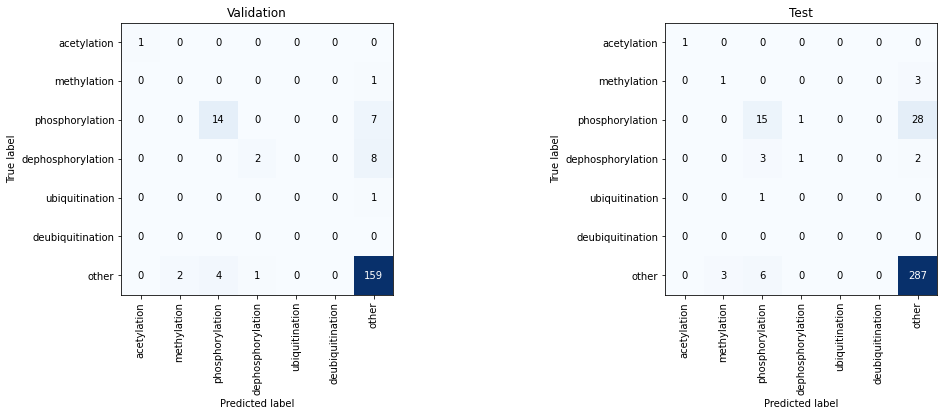

In [11]:
labels = label_order
fg, ax = plt.subplots(1,2, figsize=(20,5))

skplt.metrics.plot_confusion_matrix(df_val_ensemble["actual"], df_val_ensemble["prediction"], 
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
ax[0].set_title("Validation")


skplt.metrics.plot_confusion_matrix(df_test_ensemble["actual"], df_test_ensemble["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
ax[1].set_title("Test")




# remove color bar
ax[0].images[-1].colorbar.remove()         
ax[1].images[-1].colorbar.remove()         




plt.savefig("confusion_matrix.pdf", bbox_inches="tight")

Text(0.5, 1.0, 'Train')

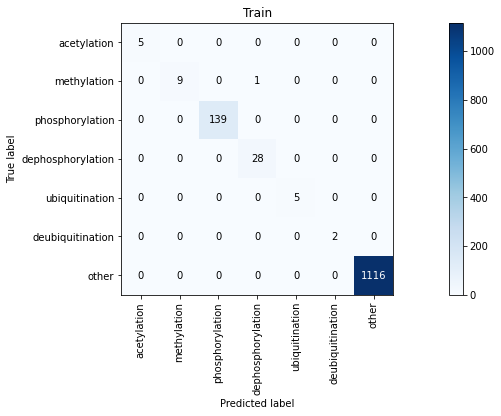

In [12]:
labels = label_order
fg, ax = plt.subplots(1,1, figsize=(20,5))

skplt.metrics.plot_confusion_matrix(df_train_ensemble["actual"], df_train_ensemble["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax)
ax.set_title("Train")

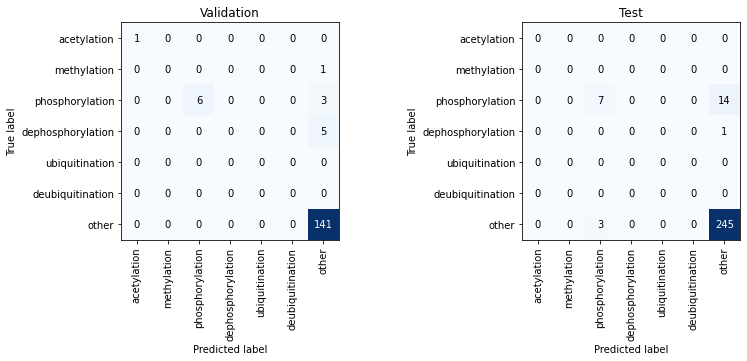

In [40]:
labels = label_order
fg, ax = plt.subplots(1,2, figsize=(15,4))

df_sub_val = df_val_ensemble.query("confidence_std < 0.15")

skplt.metrics.plot_confusion_matrix(df_sub_val["actual"], df_sub_val["prediction"], 
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
ax[0].set_title("Validation")


df_sub_test = df_test_ensemble.query("confidence_std < 0.15")
skplt.metrics.plot_confusion_matrix(df_sub_test["actual"], df_sub_test["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
ax[1].set_title("Test")


# remove color bar
ax[0].images[-1].colorbar.remove()         
ax[1].images[-1].colorbar.remove()         



plt.savefig("confusion_matrix.pdf", bbox_inches="tight")

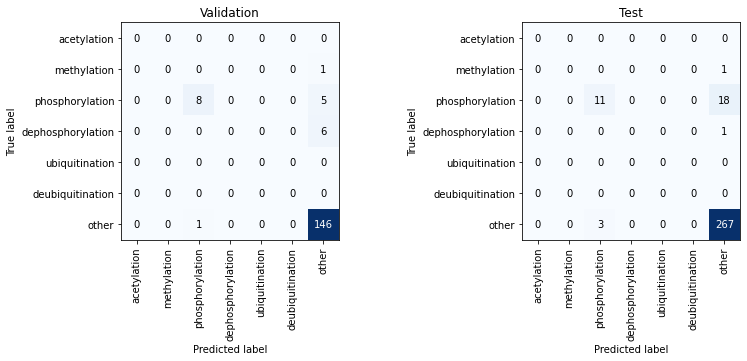

In [14]:
labels = label_order
fg, ax = plt.subplots(1,2, figsize=(15,4))

df_sub_val = df_val_ensemble.query("confidence > 0.8")

skplt.metrics.plot_confusion_matrix(df_sub_val["actual"], df_sub_val["prediction"], 
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[0])
ax[0].set_title("Validation")


df_sub_test = df_test_ensemble.query("confidence > 0.8")
skplt.metrics.plot_confusion_matrix(df_sub_test["actual"], df_sub_test["prediction"],
                                    labels=labels, normalize=False,x_tick_rotation=90, ax=ax[1])
ax[1].set_title("Test")


# remove color bar
ax[0].images[-1].colorbar.remove()         
ax[1].images[-1].colorbar.remove()         



plt.savefig("confusion_matrix.pdf", bbox_inches="tight")

In [15]:
df_test_ensemble.head()

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,normalised_abstract_annotations,participant1Id,participant2Id,gene_to_uniprot_map,...,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,correct,group_correct
0,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q13315,Q12888,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.000254,0.000344,0.000190,0.000224,other,0.996238,0.004872,"[0.9914163947105401, 0.9991012811660761, 0.998...",False,False
1,22621922,Cellular responses to DNA damage require the f...,"[{'start': '250', 'end': '275', 'name': 'vacci...",6,16,Cellular responses to DNA damage require the f...,"[{'charOffset': 250, 'len': 6, 'text': 'Q99986...",Q12888,Q99986,"{'7158': ['Q12888', 'A6NNK5'], '7443': ['Q9998...",...,0.005901,0.057876,0.014610,0.008141,phosphorylation,0.596406,0.377836,"[0.8200772404670711, 0.9964775443077081, 0.630...",True,True
2,19864627,NF-kappaB is a key activator of inflammatory a...,"[{'start': '0', 'end': '9', 'name': 'NF-kappaB...",5,15,P19838 is a key activator of inflammatory and ...,"[{'charOffset': 0, 'len': 6, 'text': 'P19838'}...",Q8WTS6,Q04206,"{'80854': ['Q8WTS6', 'B5MCZ8', 'D6RJA0'], '597...",...,0.377270,0.029645,0.101443,0.029655,other,0.440805,0.515117,"[0.004181528463959, 0.9565414190292351, 0.9814...",False,False
3,17974954,Src-specific activity has been reported to be ...,"[{'start': '0', 'end': '3', 'name': 'Src', 'ty...",6,26,P12931-specific activity has been reported to ...,"[{'charOffset': 0, 'len': 6, 'text': 'P12931'}...",P12931,P18031,"{'2221': [], '6714': ['P12931'], '5770': ['P18...",...,0.004136,0.009755,0.006600,0.004274,other,0.403810,0.413449,"[0.809972405433654, 0.9919167160987851, 0.0033...",False,False
4,18243099,Maintenance of chromosomal stability relies on...,"[{'start': '168', 'end': '187', 'name': 'monop...",3,12,Maintenance of chromosomal stability relies on...,"[{'charOffset': 168, 'len': 6, 'text': 'P33981...",P33981,Q53HL2,"{'55143': ['Q53HL2'], '7272': ['P33981'], '921...",...,0.000362,0.000485,0.000397,0.000376,other,0.768272,0.430691,"[0.9983865022659301, 0.013201974332332, 0.9387...",False,False


In [16]:
df_val_ensemble.query("prediction == 'phosphorylation'")[["correct", "prediction", "confidence", "confidence_std"]].\
sort_values(by=["confidence"])

,correct,prediction,confidence,confidence_std
9,True,phosphorylation,0.459157,0.308368
12,True,phosphorylation,0.501880,0.400489
44,False,phosphorylation,0.530192,0.454605
5,True,phosphorylation,0.536508,0.356466
13,True,phosphorylation,0.639608,0.346668
134,False,phosphorylation,0.691177,0.322723
28,True,phosphorylation,0.758381,0.334197
145,False,phosphorylation,0.773878,0.320206
11,True,phosphorylation,0.792038,0.299585
35,False,phosphorylation,0.869753,0.273559


In [17]:
df_val_ensemble.query("prediction != 'other'")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,confidence,confidence_std
16,Regulation of O60566 is central to the control...,BubR1,PCAF,19407811,True,acetylation,0.549922,0.145765
29,Mice lacking the protein-tyrosine phosphatase ...,Jak2,PTP1B,11970898,True,dephosphorylation,0.615524,0.365414
30,Mice lacking the protein-tyrosine phosphatase ...,Stat3,PTP1B,11970898,True,dephosphorylation,0.650926,0.388000
128,"LEOPARD syndrome (LS), a disorder with multipl...",GAB1/phosphoinositide 3-kinase,GAB1,20308328,False,dephosphorylation,0.665876,0.383022
152,Regulation of O60566 is central to the control...,BubR1,Cdc20,19407811,False,methylation,0.436833,0.265220
58,"P04637, the tumour suppressor and transcriptio...",LSD1,p53,17805299,False,methylation,0.684227,0.314114
9,Aneuploidy is a characteristic feature of esta...,Ect2,Plk4,20348415,True,phosphorylation,0.459157,0.308368
12,The Per-Arnt-Sim (PAS) domain serine/threonine...,PASKIN,ribosomal protein S6,21418524,True,phosphorylation,0.501880,0.400489
44,Q9NY61 is a RNA polymerase II-binding protein ...,TP53,Che-1,17157788,False,phosphorylation,0.530192,0.454605
5,The Ebola virus (EBOV) VP35 protein antagonize...,IFN-regulatory factor 3,IkappaB kinase epsilon,19153231,True,phosphorylation,0.536508,0.356466


In [18]:
df_val_ensemble.query("prediction != 'other'").shape

(24, 26)

In [19]:
df_test_ensemble.query("prediction == 'other'")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction","num_unique_gene_normalised_id",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,num_unique_gene_normalised_id,confidence,confidence_std
3,P12931-specific activity has been reported to ...,Src,PTP1B,17974954,False,other,6,0.403810,0.413449
2,P19838 is a key activator of inflammatory and ...,SET9,p65,19864627,False,other,5,0.440805,0.515117
7,Regulators of mitosis have been successfully t...,C-Nap1,salt inducible kinase 2,20708153,False,other,3,0.441963,0.453495
245,Functional inactivation of the protein tyrosin...,Src,DEP-1,18936167,True,other,6,0.481871,0.489313
339,The P31749 family of serine/threonine-directed...,phosphoinositide 3-kinase,Akt,11154276,True,other,3,0.507365,0.436857
...,...,...,...,...,...,...,...,...,...
164,The hypoxia responsive region (HRR) of the P15...,VEGF,GSK3beta,16198352,True,other,6,0.998584,0.000813
171,The hypoxia responsive region (HRR) of the P15...,PI3K,dbpB,16198352,True,other,6,0.998591,0.000875
95,Classical mammalian mitogen-activated protein ...,heat shock protein 27,ERK3,21575178,True,other,6,0.998597,0.000846
170,The hypoxia responsive region (HRR) of the P15...,PI3K,GSK3beta,16198352,True,other,6,0.998601,0.000801


In [36]:
import matplotlib.gridspec as gridspec


def _plot_violin_color(ax, data, color, max_x):
    
    ax.set_ylim([0,1])
    ax.set_xlim([0,max_x])
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    
    parts = ax.violinplot(data,  showmeans=True )
    
    
    
    for pc in parts['bodies']:
        pc.set_edgecolor('white')
        pc.set_facecolor(color)


        pc.set_alpha(1)
        
    # Make all the violin statistics marks red:
    for partname in ('cbars','cmins','cmaxes', "cmeans"):
        vp = parts[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)
        
    
#     parts['cmeans'].set_edgecolor("white")
#     parts['cmeans'].set_linewidth(2)


                      
                      
def plot_violin(data,  ax_correct, ax_incorrect, max_x):
    
    
    is_correct = (data["actual"] == data["prediction"]).tolist()


    is_incorrect = [ not i for i in is_correct]
    
    
    if any(is_correct):
        correct_data= data[is_correct]
        _plot_violin_color(ax_correct, correct_data["raw_confidence"], color ='orange', max_x=max_x)
    
  
    
    if any(is_incorrect):
        incorrect_data = data[is_incorrect]
        _plot_violin_color(ax_incorrect, incorrect_data["raw_confidence"], color ='skyblue', max_x=max_x)
    

def plot_violin_classwise(df, fig, subplot_spec, title_prefix, labels_to_plot, max_x=15):
    
    
    
    
    pred_labels = sorted( list(df["prediction"].unique()), key=label_order_key )
 
    index_sorted_labels = sorted (df["actual"].unique(), key=lambda x: label_mapper.map(x) )
    
    num_plots = len(set(pred_labels).intersection(set(labels_to_plot))) 
    
    gs = gridspec.GridSpecFromSubplotSpec( num_plots,2, subplot_spec=subplot_spec)

    for i,l in enumerate(filter(lambda x: x  in labels_to_plot,  pred_labels)):
            
        df_label = df.query(f"prediction == '{l}'")
        
        if len(df_label) == 0: continue
        
        
        ax1 = fig.add_subplot(gs[i,0])
        ax2 = fig.add_subplot(gs[i,1])
        
       
        ax1.set_ylabel("Predicted confidence")
        
    

        ax1.set_title("{}{}".format( title_prefix, label_title_map.get(l, l).title()))
        plot_violin(df_label.sort_values(by=["confidence"]),ax1, ax2,max_x=max_x )
        
    
#     # All labels
#     ax1 = fig.add_subplot(gs[0, -1])
#     ax2 = fig.add_subplot(gs[1, -1])



#     ax1.set_title("{}{}".format( title_prefix, "All"))
#     plot_violin(df,ax1, ax2 )



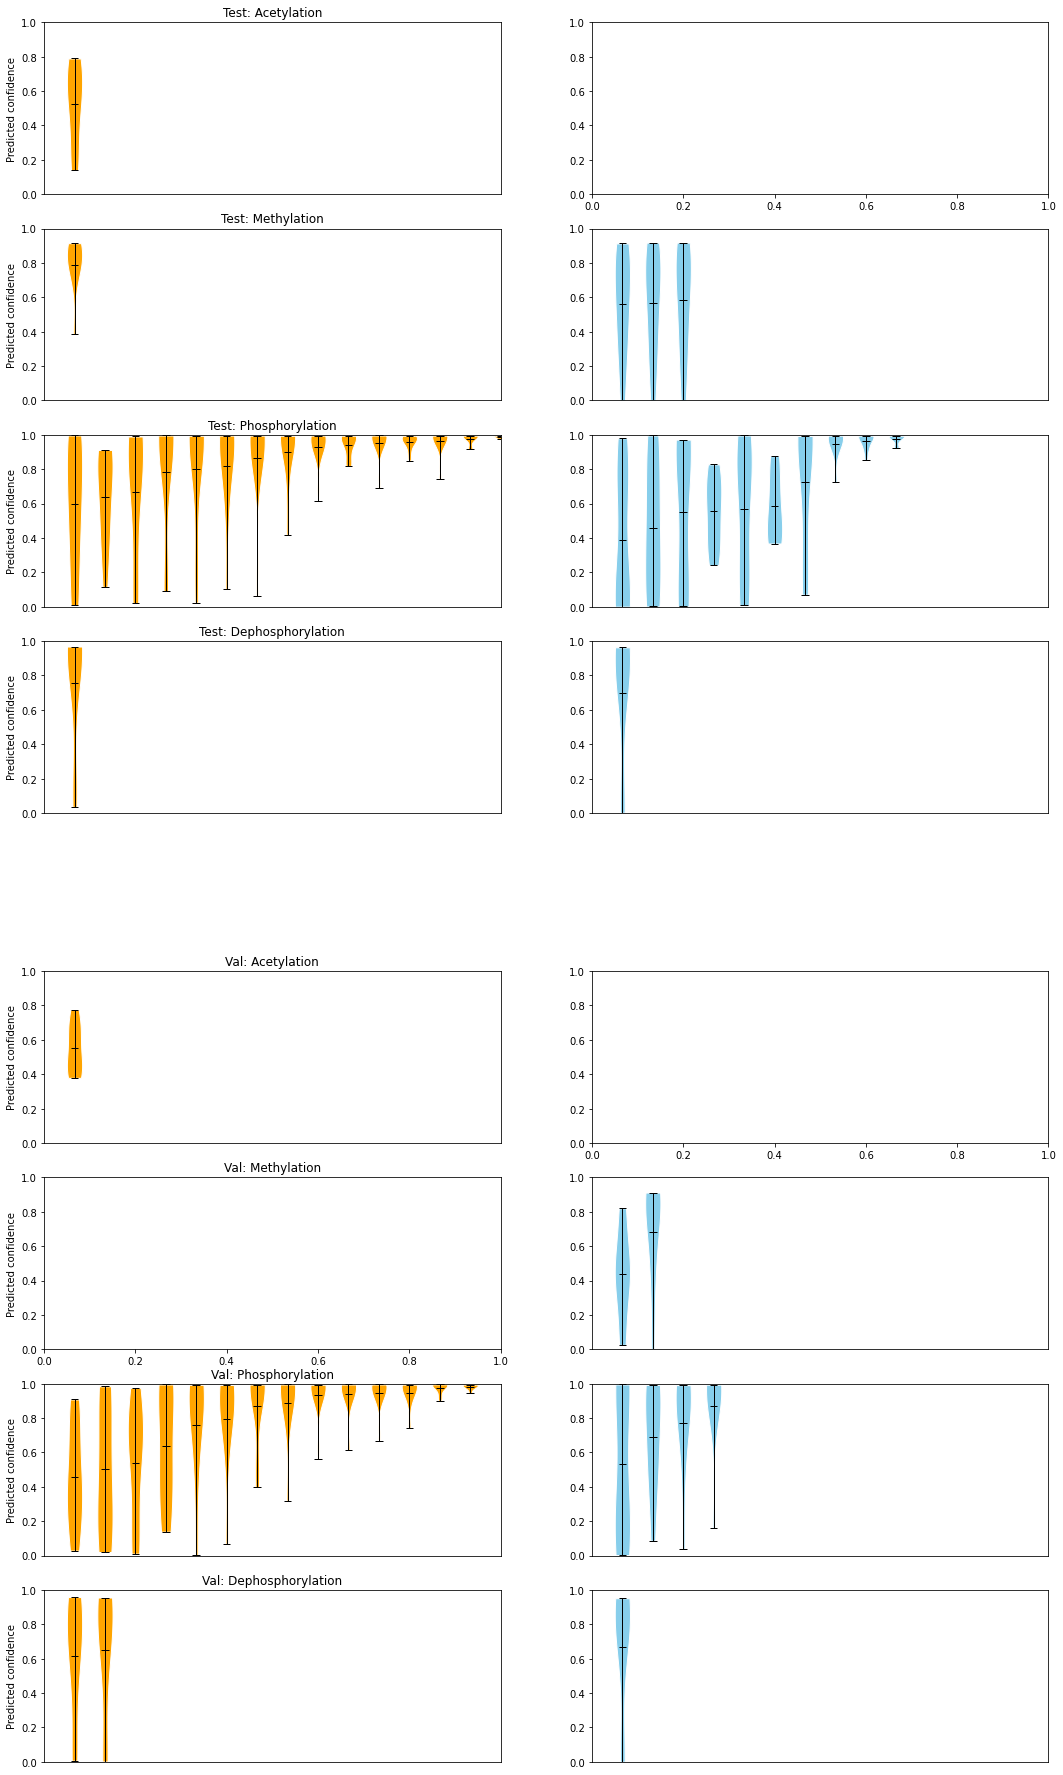

In [39]:

fig = plt.figure(figsize=(18 , 32))
gs = fig.add_gridspec(nrows=2)

plot_violin_classwise(df_test_ensemble, fig, gs[0], "Test: ", labels_to_plot=pos_labels)

plot_violin_classwise(df_val_ensemble, fig, gs[1], "Val: ", labels_to_plot=pos_labels)







plt.savefig("variation_violin.pdf", bbox_inches="tight")

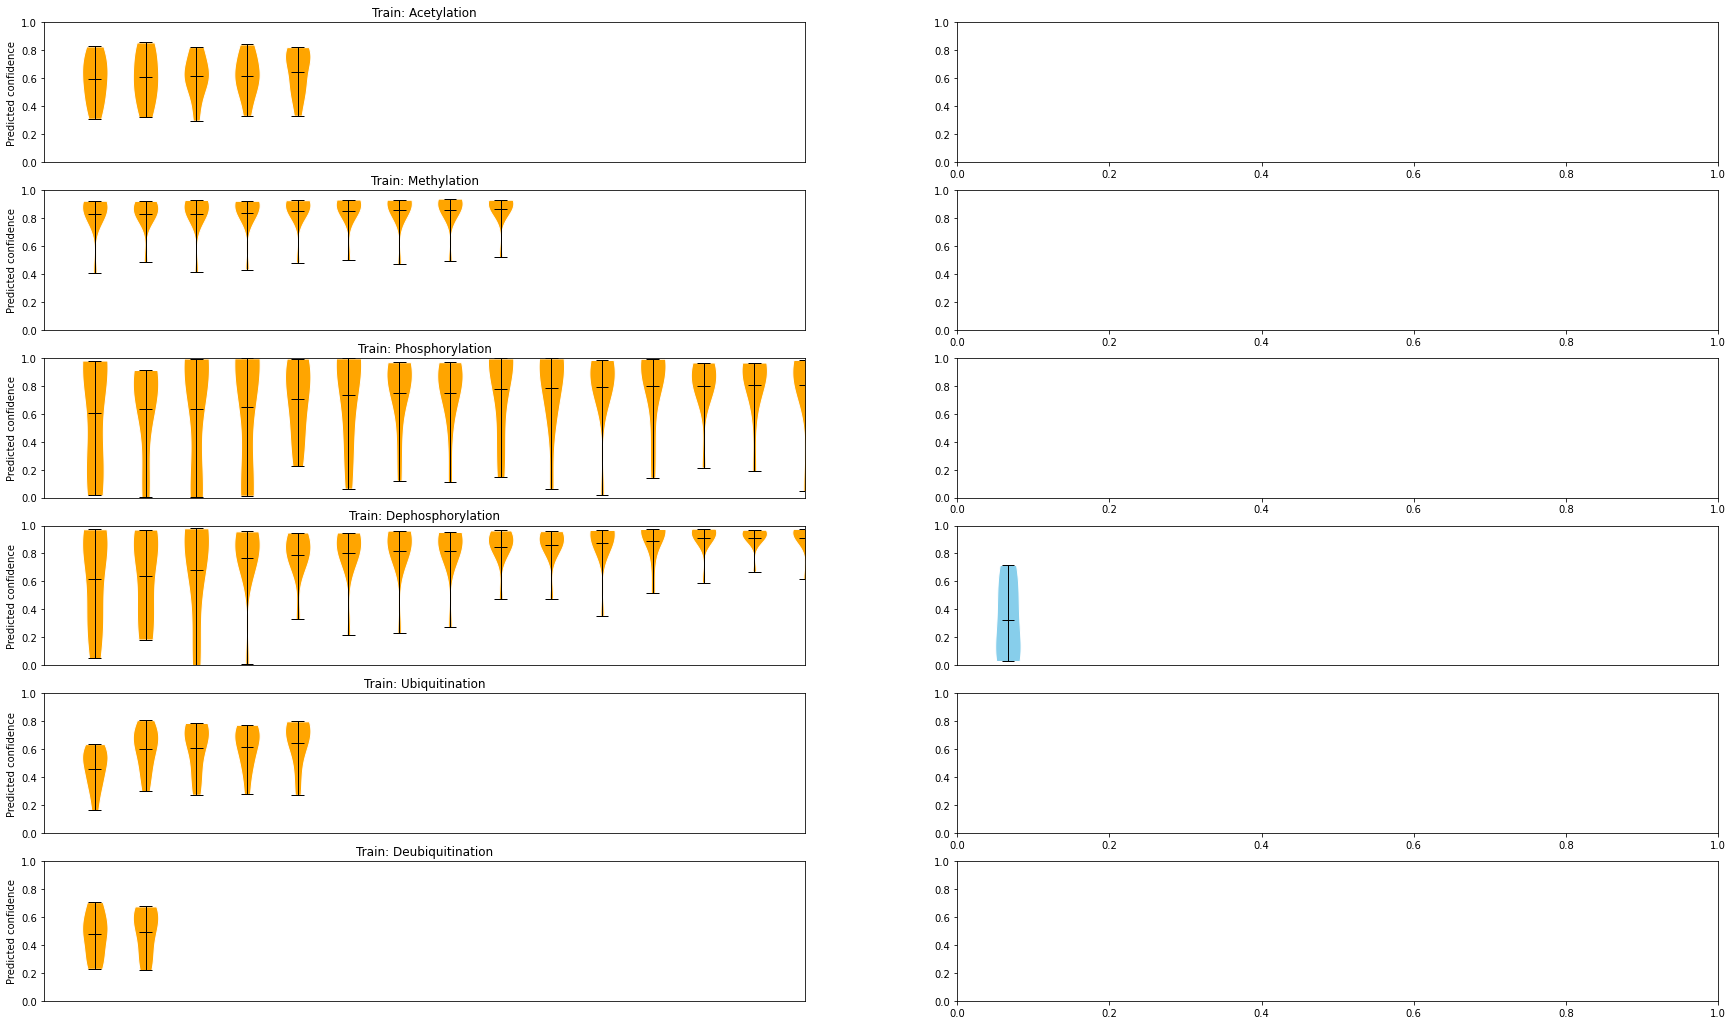

In [22]:
fig = plt.figure(figsize=(30 , 18))
gs = fig.add_gridspec(ncols=1)


plot_violin_classwise(df_train_ensemble, fig, gs[0], "Train: ", labels_to_plot=pos_labels)



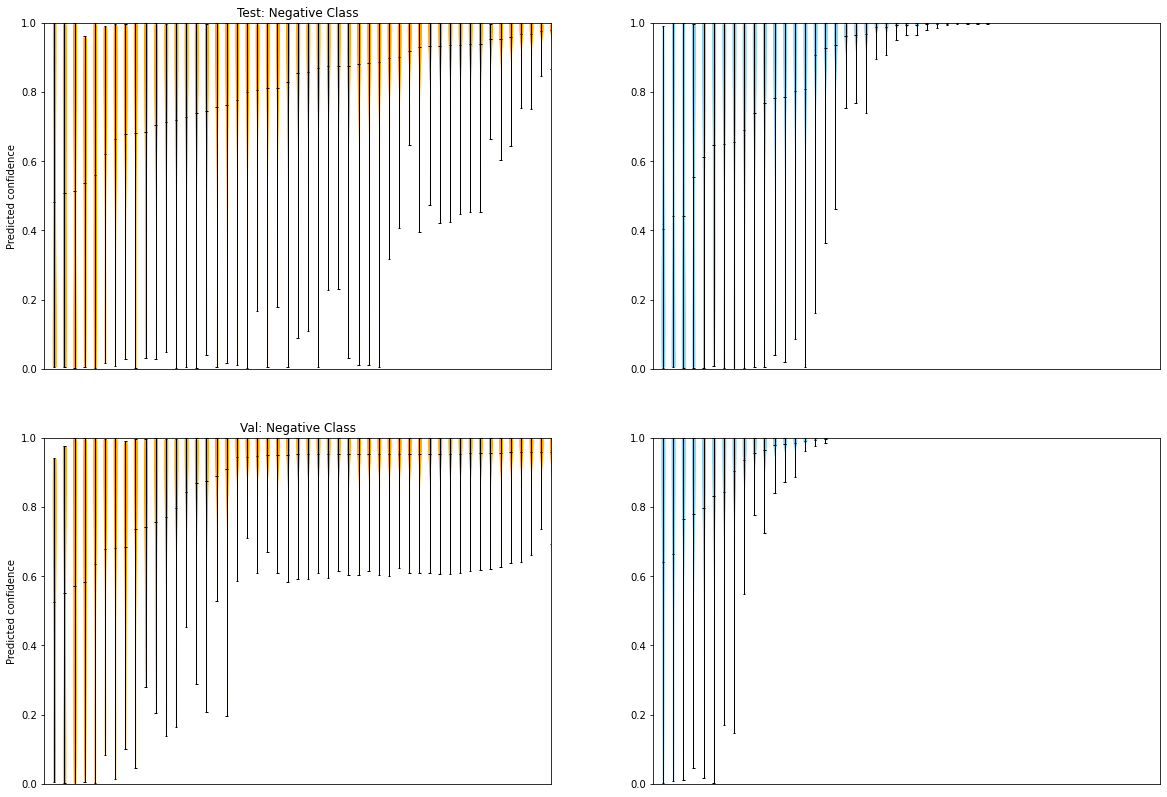

In [23]:

fig = plt.figure(figsize=(20 , 14))
gs = fig.add_gridspec(nrows=2)

plot_violin_classwise(df_test_ensemble, fig, gs[0], "Test: ", labels_to_plot=["other"], max_x=50)

plot_violin_classwise(df_val_ensemble, fig, gs[1], "Val: ", labels_to_plot=["other"],  max_x=50)






plt.savefig("variation_negative.pdf", bbox_inches="tight")

In [24]:
df_test_ensemble.query("prediction == 'other' and correct == False")[["normalised_abstract","participant1Name"
                                                           ,"participant2Name" ,
                                                           "pubmedId", "correct",
                                                           "prediction",
                                                           "confidence", "confidence_std"]].\
sort_values(by=["prediction","confidence", "confidence_std"])

,normalised_abstract,participant1Name,participant2Name,pubmedId,correct,prediction,confidence,confidence_std
3,P12931-specific activity has been reported to ...,Src,PTP1B,17974954,False,other,0.403810,0.413449
2,P19838 is a key activator of inflammatory and ...,SET9,p65,19864627,False,other,0.440805,0.515117
7,Regulators of mitosis have been successfully t...,C-Nap1,salt inducible kinase 2,20708153,False,other,0.441963,0.453495
39,By GST pull downs and co-immunoprecipitation a...,Chk2,HDM2,15862297,False,other,0.553733,0.493345
28,The hypoxia responsive region (HRR) of the P15...,ERK2,dbpA,16198352,False,other,0.613123,0.460861
33,The E3 ubiquitin ligase Pellino can be activat...,IRAK4,Pellino 1,19264966,False,other,0.645818,0.392790
24,Control of centrosome duplication is tightly l...,centrosomal P4.1-associated protein,PLK4,20531387,False,other,0.650029,0.487053
42,The protein lysine methyltransferase 57108 reg...,AKT1,DNA methyltransferase-1,21151116,False,other,0.654926,0.462854
49,"When exposed to ionizing radiation (IR), eukar...",Cdc25A,Chk2,11298456,False,other,0.690157,0.395399
27,The hypoxia responsive region (HRR) of the P15...,dbpB,ERK2,16198352,False,other,0.738196,0.417947


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from scorers.result_scorer_ece import ResultScorerEce


class PlotReliability:

    def __init__(self, num_bins=10):
        self.num_bins = num_bins

    def plot(self, y_actual, y_pred_conf, *, ax_r=None, ax_c=None, **kwargs):
        
        # Get scorer
        scorer= ResultScorerEce()
        ece_error = round( scorer(y_actual, y_pred_conf),2)
        ece_values = scorer.get_bin_values(y_actual, y_pred_conf)
        
        # Get bin values
        bins = np.array(ece_values["bins"])
        expected_accuracy_bins=ece_values["expected_accuracy"]
        actual_accuracy_bins=np.array(ece_values["actual_accuracy"])
        conf_bins= np.array(ece_values["average_confidence"])
        num_items_in_bin =  np.array(ece_values["num_items_in_bin"])
        num_items_in_bin_percent=np.around(num_items_in_bin/len(y_actual) ,decimals=2)
        
        avg_acc = np.mean(actual_accuracy_bins[~np.isnan(actual_accuracy_bins)])
        avg_conf = np.mean(conf_bins[~np.isnan(actual_accuracy_bins)])


            
        # Compute diff between expected vs actual
        diff = np.array(expected_accuracy_bins) - np.array(actual_accuracy_bins)
        under_expected = np.where(diff < 0, 0, diff)
        over_expected = np.where(diff > 0, 0, -1 * diff)
        
        # Zero out if no predictions in that bin
        under_expected = np.where(num_items_in_bin == 0, 0, under_expected)
        over_expected = np.where(num_items_in_bin == 0, 0, over_expected)
      
        
        # Start plotting
        ax_r = ax_r or plt.subplots(1, 1, figsize=(3, 3))[1]
        ax_c = ax_c or plt.subplots(1, 1, figsize=(3, 3))[1]
        
        ax_c.spines['bottom'].set_color('grey')
        ax_c.spines['top'].set_color('grey') 
        ax_c.spines['right'].set_color('grey')
        ax_c.spines['left'].set_color('grey')
        
        ax_r.spines['bottom'].set_color('grey')
        ax_r.spines['top'].set_color('grey') 
        ax_r.spines['right'].set_color('grey')
        ax_r.spines['left'].set_color('grey')

        bin_width = bins[1]-bins[0]
        
        
        # Plot confidence 
        ax_c.set_ylim([0,1])
        ax_c.set_xlim([0,1])
        ax_c.bar(bins[:-1], num_items_in_bin_percent, width=bin_width, bottom=None, align='edge', color="deepskyblue",
                 edgecolor="white", data=None, **kwargs)
        
        ax_c.plot([avg_conf for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="red", **kwargs, label="Average confidence"  )
        ax_c.plot([avg_acc for i in range(0,10)], [i/10 for i in range(0,10)],'--', color="blue", **kwargs, label="Average accuracy" )
       



        
        # Plot reliablity
        ax_r.set_ylim([0,1])
        ax_r.set_xlim([0,1])
        # Zero where accuracy is nan
        base_bar_data =  np.where(np.isnan(actual_accuracy_bins), 0, actual_accuracy_bins) 
        # Max expect
        base_bar_data =  np.minimum(base_bar_data, expected_accuracy_bins) 

        ax_r.bar(bins[:-1], base_bar_data, width=bin_width, bottom=None, align='edge', color="lightblue",
                 edgecolor="white", data=None, label="Expected accuracy", **kwargs)
        ax_r.bar(bins[:-1], under_expected, width=bin_width, bottom=base_bar_data, align='edge',
                 color="palevioletred", edgecolor="white", data=None, label="Gap", **kwargs)
        ax_r.bar(bins[:-1], over_expected, width=bin_width, bottom=base_bar_data, align='edge',
                 color="forestgreen", edgecolor="white", data=None, label="Above expected accuracy", **kwargs, )
        ax_r.plot( (bins[1:]+  bins[:-1])/2, expected_accuracy_bins, '--', color="red", data=None, **kwargs)






In [26]:

import matplotlib.gridspec as gridspec

def plot_classwise_conf_hist(df, fig, subplot_spec, title_prefix):
    
    pred_labels = sorted( list(df["prediction"].unique()), key=label_order_key )
 
    sorted_labels = sorted (df["actual"].unique(), key=lambda x: label_mapper.map(x) )
    
    num_plots = len(pred_labels) + 1
    
    gs = gridspec.GridSpecFromSubplotSpec(2, num_plots, subplot_spec=subplot_spec)
    
    


    
    reliablity_plot = PlotReliability()
    for i,l in enumerate(pred_labels):
        df_label = df.query(f"prediction == '{l}'")
        
        actual_indices = df_label["actual"].apply(label_mapper.map)
        predicted_conf = df_label[sorted_labels]
        
        ax1 = fig.add_subplot(gs[0, i])
        ax2 = fig.add_subplot(gs[1, i])


        ax1.set_title("{}{}".format( title_prefix, label_title_map.get(l, l).title()))
        reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax1, ax_c=ax2)
        
    
    actual_indices = df["actual"].apply(label_mapper.map)
    predicted_conf = df[sorted_labels]
        
    ax_r = fig.add_subplot(gs[0, -1])
    ax_c = fig.add_subplot(gs[1, -1])
    ax_r.set_title("All")
    reliablity_plot.plot(actual_indices, predicted_conf, ax_r= ax_r, ax_c=ax_c)
    
    ax_r.legend()
    ax_c.legend()    
    return fig
    

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/p

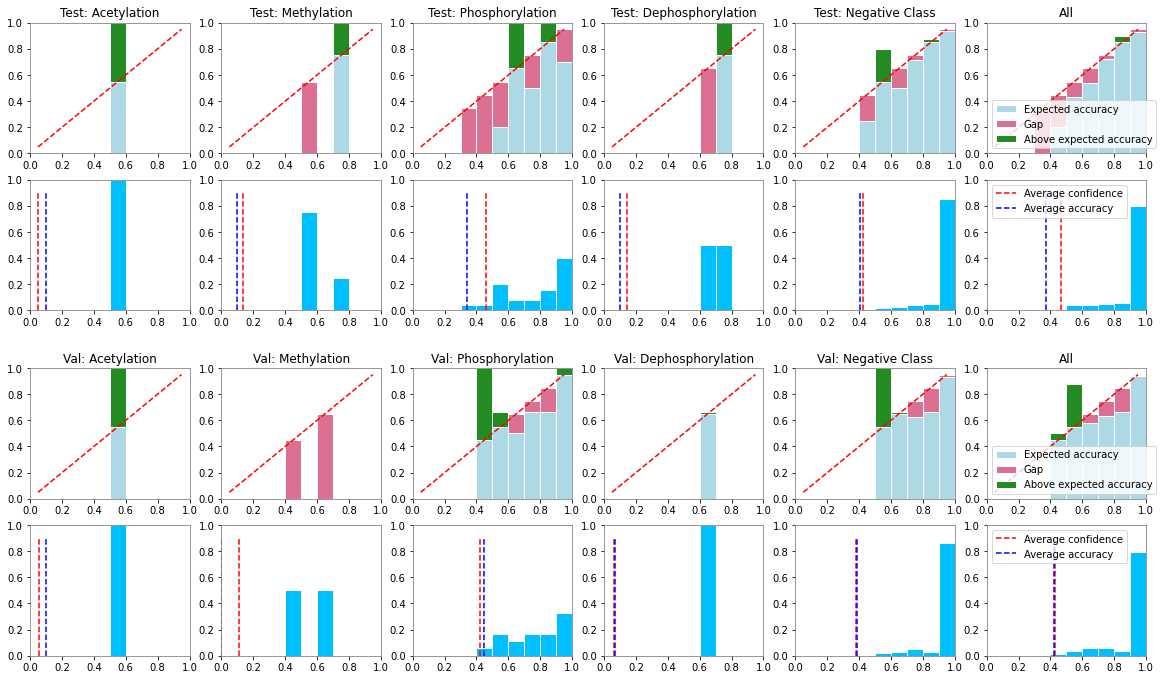

In [35]:

fig = plt.figure(figsize=(20 , 18))
gs = fig.add_gridspec(3)

plot_classwise_conf_hist(df_test_ensemble, fig, gs[0], "Test: ")

plot_classwise_conf_hist(df_val_ensemble, fig, gs[1], "Val: ")


plt.savefig("reliability.pdf", bbox_inches="tight")

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/venv/ppi-aimed/lib/p

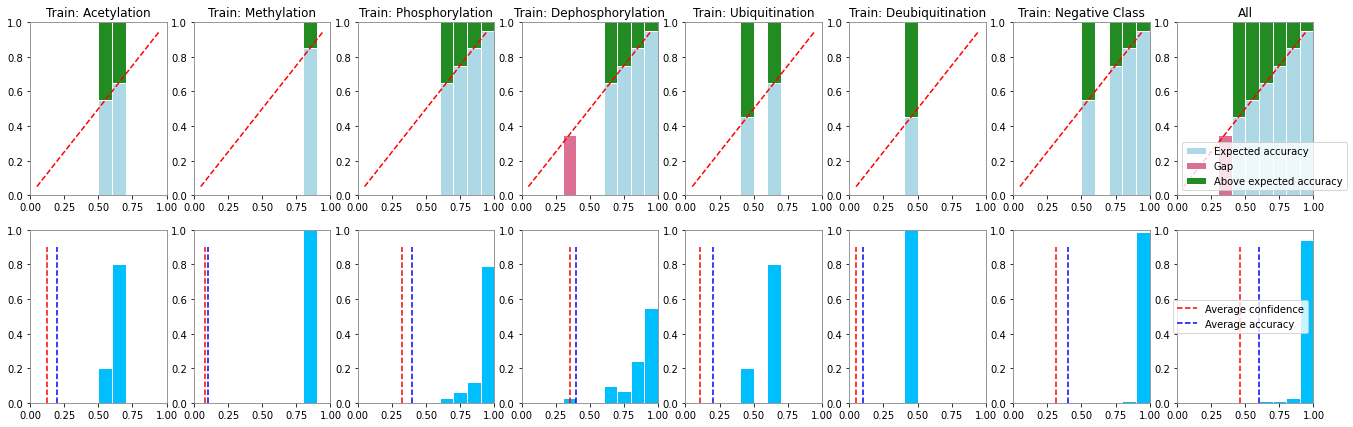

In [28]:

fig = plt.figure(figsize=(23 , 7))
gs = fig.add_gridspec(1)

d = plot_classwise_conf_hist(df_train_ensemble, fig, gs[0], "Train: ")



In [29]:
pos_labels = list(set(df_test_ensemble["actual"].unique().tolist()) - set(['other']))

df_test_report, test_summary = create_classification_report(df_test_ensemble, "actual", "prediction", 
                                                            "confidence_std",
                                                           labels=pos_labels)
df_val_report, val_summary = create_classification_report(df_val_ensemble,"actual", 
                                                          "prediction",
                                                          "confidence_std",
                                                          labels=pos_labels)

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-ai

In [30]:
df_test_report

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,phosphorylation,0.6,0.340909,0.434783,0.779856,0.273292,44,False
1,acetylation,1,1,1,0.523911,0.241042,1,False
2,ubiquitination,0,0,0,<NA>,NaN,1,False
3,dephosphorylation,0.5,0.166667,0.25,0.726846,0.384627,6,False
4,methylation,0.25,0.25,0.25,0.625993,0.284078,4,False
5,micro avg,0.5625,0.321429,0.409091,<NA>,0.284078,56,True
6,macro avg,0.47,0.351515,0.386957,<NA>,0.284078,56,True
7,weighted avg,0.560714,0.321429,0.404115,<NA>,0.284078,56,True
8,ECE,<NA>,<NA>,<NA>,0.749312,<NA>,32,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.281957,32,True


In [31]:
df_val_report

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,phosphorylation,0.777778,0.666667,0.717949,0.779554,0.273942,21,False
1,acetylation,1,1,1,0.549922,0.145765,1,False
2,ubiquitination,0,0,0,<NA>,NaN,1,False
3,dephosphorylation,0.666667,0.2,0.307692,0.644109,0.378936,10,False
4,methylation,0,0,0,0.56053,0.290697,1,False
5,micro avg,0.708333,0.5,0.586207,<NA>,0.290697,34,True
6,macro avg,0.488889,0.373333,0.405128,<NA>,0.290697,34,True
7,weighted avg,0.705882,0.5,0.563348,<NA>,0.290697,34,True
8,ECE,<NA>,<NA>,<NA>,0.734803,<NA>,24,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.286635,24,True


In [32]:
t,  _ = create_classification_report(df_test_ensemble.query("confidence_std < 0.25"), "actual", "prediction", 
                                                            "confidence_std",
                                                           labels=pos_labels)
t

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aeg/venv/ppi-aimed/lib/

,interactionType,precision,recall,f1-score,ece,average-confidence-var,support,isSummary
0,phosphorylation,0.615385,0.347826,0.444444,0.89498,0.117722,23,False
1,acetylation,1,1,1,0.523911,0.241042,1,False
2,ubiquitination,0,0,0,<NA>,NaN,0,False
3,dephosphorylation,0,0,0,<NA>,NaN,2,False
4,methylation,1,0.5,0.666667,0.789082,0.164691,2,False
5,micro avg,0.666667,0.357143,0.465116,<NA>,0.164691,28,True
6,macro avg,0.523077,0.369565,0.422222,<NA>,0.164691,28,True
7,weighted avg,0.612637,0.357143,0.448413,<NA>,0.164691,28,True
8,ECE,<NA>,<NA>,<NA>,0.863182,<NA>,15,True
9,average-confidence-var,<NA>,<NA>,<NA>,<NA>,0.133012,15,True


In [33]:
df_test_report["dataset"]="Test"
df_val_report["dataset"]="Val"
df_temp_latex =pd.concat([ df_test_report, df_val_report])

def float_format(x):
    if  x in ("<NA>", "nan" ): return "-"
    
    return  "{:0.2f}".format(float(x))

def float_percent_format(x):
    if  x in ("<NA>", "nan" ) : return "-"
    
    return "{:0.2%}".format(float(x))

    
print(df_temp_latex
    .sort_values(by=["dataset" , "isSummary", "interactionType" ] )[["dataset", "interactionType", 
                                                      "precision", "recall", "f1-score",
                                                      "ece", 
                                                     "average-confidence-var",
                                                      "support"]]
      
      .applymap(str)
      .to_latex(index=False, 
               na_rep="-",
              formatters = {
                  "ece" :float_format  ,
                  "precision": float_percent_format,
                  "recall" : float_percent_format,
                  "f1-score" : float_percent_format,
                  "average-confidence-var" : float_format
                  
              }
               ).replace("\\%","")
     )



\begin{tabular}{llllllll}
\toprule
dataset &         interactionType & precision &   recall & f1-score &   ece & average-confidence-var & support \\
\midrule
   Test &             acetylation &   100.00 &  100.00 &  100.00 &  0.52 &                   0.24 &       1 \\
   Test &       dephosphorylation &    50.00 &   16.67 &   25.00 &  0.73 &                   0.38 &       6 \\
   Test &             methylation &    25.00 &   25.00 &   25.00 &  0.63 &                   0.28 &       4 \\
   Test &         phosphorylation &    60.00 &   34.09 &   43.48 &  0.78 &                   0.27 &      44 \\
   Test &          ubiquitination &     0.00 &    0.00 &    0.00 &     - &                      - &       1 \\
   Test &                     ECE &         - &        - &        - &  0.75 &                      - &      32 \\
   Test &  average-confidence-var &         - &        - &        - &     - &                   0.28 &      32 \\
   Test &               macro avg &    47.00 &   35.15 &   